In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler, Subset, random_split
import cv2


cudnn.benchmark = True
plt.ion()

In [2]:
!ls

data.zip  sample_data


In [3]:
!unzip data.zip
%ls

Archive:  data.zip
   creating: data/
   creating: data/normal/
  inflating: data/normal/1.jpg       
  inflating: data/normal/10.jpg      
  inflating: data/normal/100.jpg     
  inflating: data/normal/101.jpg     
  inflating: data/normal/102.jpg     
  inflating: data/normal/103.jpg     
  inflating: data/normal/104.jpg     
  inflating: data/normal/105.jpg     
  inflating: data/normal/106.jpg     
  inflating: data/normal/107.jpg     
  inflating: data/normal/108.jpg     
  inflating: data/normal/109.jpg     
  inflating: data/normal/11.jpg      
  inflating: data/normal/110.jpg     
  inflating: data/normal/111.jpg     
  inflating: data/normal/112.jpg     
  inflating: data/normal/113.jpg     
  inflating: data/normal/114.jpg     
  inflating: data/normal/115.jpg     
  inflating: data/normal/116.jpg     
  inflating: data/normal/117.jpg     
  inflating: data/normal/118.jpg     
  inflating: data/normal/119.jpg     
  inflating: data/normal/12.jpg      
  inflating: data/normal

In [4]:
class ImageDataset(Dataset):
    def __init__(self, dataset_dir, train=False):
        self.data_transforms = {
                            'train': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                            'val': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                        }
        self.dataset_dir = dataset_dir

        self.labels = []
        self.raw_images = []
        self.train = train

        for dirpath, dirnames, filenames in os.walk(dataset_dir):
            for fn in filenames:
                label = 0 if 'normal' in dirpath else 1
                raw_img = cv2.imread(f'{dirpath}/{fn}')
                self.labels.append(label)
                self.raw_images.append(raw_img)

        self.train_images = [self.data_transforms['train'](img) for img in self.raw_images]
        self.test_images = [self.data_transforms['val'](img) for img in self.raw_images]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.train:
            return self.train_images[idx], self.labels[idx]
        else:
            return self.test_images[idx], self.labels[idx]

In [5]:
data_dir = 'data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
n_images = 0
for dirpath, dirnames, filenames in os.walk(data_dir):
    n_images += len(filenames)

In [7]:
n_images

400

In [8]:
image_idxs = np.arange(n_images)

In [9]:
dataset = ImageDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [10]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [11]:
class_names = {0: 'normal', 1: 'phishing'}

In [12]:
device

device(type='cuda', index=0)

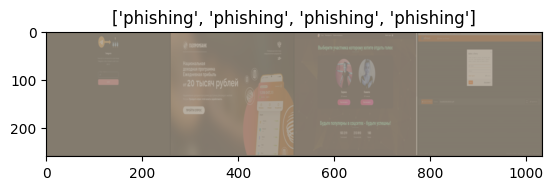

In [13]:
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])

In [14]:
import torch.nn.functional as F

In [15]:
class Encoder(nn.Module):
    def __init__(self, image_size, channels, embedding_dim):
        super(Encoder, self).__init__()

        self.channels = channels
        self.image_size = image_size
        self.embedding_dim = embedding_dim

        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.shape_before_flattening = self.calculate_shape()
        flattened_size = (image_size // 8) * (image_size // 8) * 128
        self.fc = nn.Linear(flattened_size, embedding_dim)

    @torch.no_grad()
    def calculate_shape(self):
        x = torch.zeros((1, self.channels, self.image_size, self.image_size))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x.shape[1:]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        return x

In [16]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        self.reshape_dim = shape_before_flattening

        self.deconv1 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        x = x.view(x.size(0), *self.reshape_dim)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.conv1(x))
        return x

In [17]:
class ConvAutoencoder(nn.Module):
    def __init__(self, image_size, channels, embedding_dim, n_classes=1):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(image_size, channels, embedding_dim)
        self.decoder = Decoder(embedding_dim, self.encoder.shape_before_flattening, channels)
        self.classifier = nn.Linear(embedding_dim, n_classes)

    def forward(self, x):
        embeddings = self.encoder(x)
        faked = self.decoder(embeddings)
        return faked

    def get_embeddings(self, x):
        embeddings = self.encoder(x)
        return embeddings


In [18]:
def train_autoencoder(num_epochs=25, model=None):
    since = time.time()
    sigm = nn.Sigmoid()

    train_losses = []
    val_losses = []

    best_model_params_path = os.path.join('.', 'autoencoder_best_model_params.pt')

    best_loss = 1000

    img_shape = dataset[0][0].shape
    if model is None:
        model = ConvAutoencoder(img_shape[1], img_shape[0], 1, 1)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    warmup_epochs = 5
    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / warmup_epochs)

    main_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                loader = train_loader
                model.train()
            else:
                loader = test_loader
                model.eval()

            running_loss = 0.0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = torch.unsqueeze(labels, 1).type('torch.FloatTensor').to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                fold_train_loss = running_loss / train_size
                train_losses.append(fold_train_loss)
                print(f'\t\ttrain loss: {fold_train_loss}')
            else:
                fold_val_loss = running_loss / test_size
                val_losses.append(fold_val_loss)
                print(f'\t\tval loss: {fold_val_loss}')

        if epoch < warmup_epochs:
            warmup_scheduler.step()
        else:
            main_scheduler.step()

        if val_losses[epoch] < best_loss:
            best_loss = val_losses[epoch]
            torch.save(model.state_dict(), best_model_params_path)

    torch.save(model.state_dict(), best_model_params_path)

    time_elapsed = time.time() - since
    print()
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best mean val loss: {best_loss:.4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    return model

Epoch: 0/49
----------
		train loss: 0.14285381184890866
		val loss: 0.14177160821855067
Epoch: 1/49
----------
		train loss: 0.10639777723699809
		val loss: 0.06279052216559648
Epoch: 2/49
----------
		train loss: 0.030894814035855235
		val loss: 0.031571770831942556
Epoch: 3/49
----------
		train loss: 0.020568921498488636
		val loss: 0.01843226598575711
Epoch: 4/49
----------
		train loss: 0.015967776294564827
		val loss: 0.017980962665751575
Epoch: 5/49
----------
		train loss: 0.01442654812708497
		val loss: 0.017460356443189086
Epoch: 6/49
----------
		train loss: 0.016060193727025763
		val loss: 0.014501902926713228
Epoch: 7/49
----------
		train loss: 0.013349310006015002
		val loss: 0.014109841780737042
Epoch: 8/49
----------
		train loss: 0.027773956407327206
		val loss: 0.012802033452317119
Epoch: 9/49
----------
		train loss: 0.012105824111495167
		val loss: 0.013612274406477809
Epoch: 10/49
----------
		train loss: 0.010075228189816699
		val loss: 0.00856270375661552
Epoch

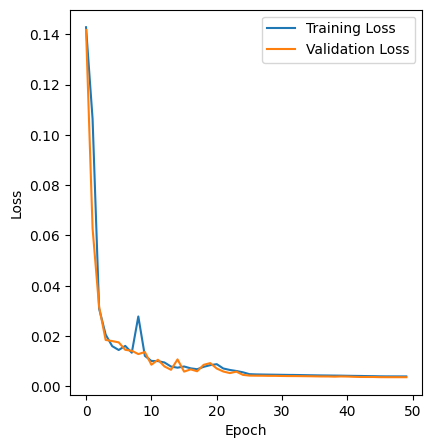

In [19]:
last_autoencoder = train_autoencoder(50)

In [20]:
img_shape = dataset[0][0].shape
autoencoder  = ConvAutoencoder(img_shape[1], img_shape[0], 1, 1)
autoencoder.load_state_dict(torch.load('autoencoder_best_model_params.pt'))
autoencoder  = autoencoder .to(device)

In [21]:
import random

In [22]:
def plot_random_autoencoder(ds : Dataset, autoenc):
    idx = random.randint(0, len(ds)-1)
    image, label = ds[idx]
    x = image.unsqueeze(0).to(device)

    autoenc.eval()
    with torch.no_grad():
        restored_image = autoenc(x).squeeze(0).cpu().detach().numpy()

    fig, axs = plt.subplots(ncols=2, figsize=(8, 8), layout='tight')

    image = np.swapaxes(image, 0, -1)
    restored_image = np.swapaxes(restored_image, -1, 0)

    axs[0].imshow(image)
    axs[0].set_title('Original image')
    axs[1].imshow(restored_image)
    axs[1].set_title('Faked image')

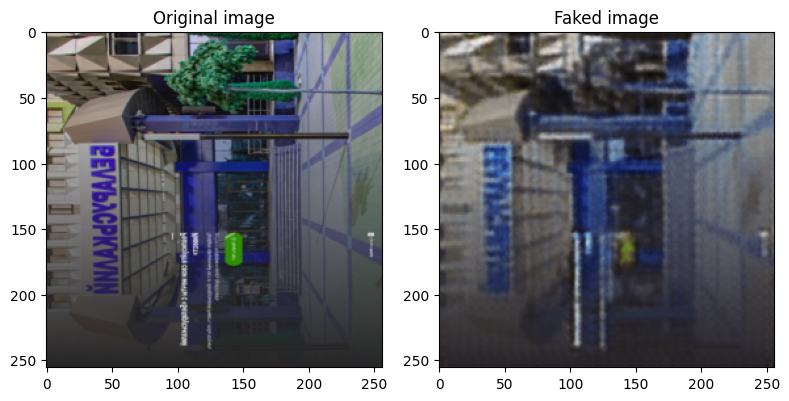

In [23]:
plot_random_autoencoder(test_dataset, last_autoencoder)

In [24]:
def get_embeddings(ds : Dataset, autoenc, idxs=None):
    embeddings = []
    labels = []

    if idxs is None:
        for image, label in ds:
            labels.append(label)

            x = image.unsqueeze(0).to(device)
            embed = autoenc.encoder(x).squeeze(0).cpu().detach().numpy()
            embeddings.append(embed)
    else:
        for i in idxs:
            image, label = ds[i]
            labels.append(label)

            x = image.unsqueeze(0).to(device)
            embed = autoenc.encoder(x).squeeze(0).cpu().detach().numpy()
            embeddings.append(embed)
    return embeddings, labels

In [25]:
embeddings, labels = get_embeddings(test_dataset, autoencoder)

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=2)

In [28]:
embed_matrix = np.array(embeddings)
labels = np.array(labels)

pca_matrix = pca.fit_transform(embed_matrix)

Text(0.5, 1.0, 'Train embeddings Normal/Fake')

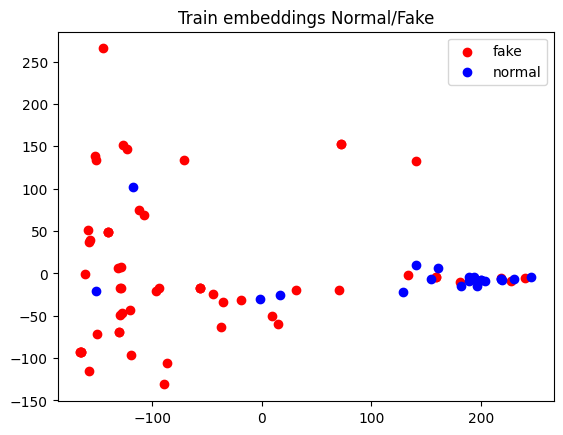

In [29]:
fake_examples = np.where(labels == 1)[0]
normal_examples = np.where(labels == 0)[0]

plt.scatter(pca_matrix[fake_examples, 0], pca_matrix[fake_examples, 1], color='red', label='fake')
plt.scatter(pca_matrix[normal_examples, 0], pca_matrix[normal_examples, 1], color='blue', label='normal')
plt.legend()
plt.title('Train embeddings Normal/Fake')

In [30]:
fishing_idxs = []
true_idxs = []

In [31]:
for i, (_, label) in enumerate(train_dataset):
    if label == 0:
        true_idxs.append(i)
    else:
        fishing_idxs.append(i)

In [32]:
fishing_idxs = np.array(fishing_idxs)
true_idxs = np.array(true_idxs)

In [33]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [66]:
def get_single_embedding(ds : Dataset, autoenc, idx=None):
    if idx is None:
        idx = random.randint(0, len(ds)-1)
    image, label = ds[idx]
    x = image.unsqueeze(0).to(device)
    embed = autoenc.encoder(x).squeeze(0).cpu().detach().numpy()
    faked_image = autoenc(x).squeeze(0).cpu().detach().numpy()
    return image, faked_image, embed, label

def cos_distance(v1, v2):
    return 1 - (np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

def analyse_embeds(ds : dataset, autoenc, relative_idx, k=50):
    global true_idxs

    image, restored_image, fake_embed, label = get_single_embedding(ds, autoenc, relative_idx)
    plt.show()
    all_embeddings, labels = get_embeddings(ds, autoenc)

    distances = np.zeros(len(all_embeddings))

    for i, v in enumerate(all_embeddings):
        distances[i] = cos_distance(v, fake_embed)

    sorted_idxs = np.argsort(distances)
    distances = distances[sorted_idxs]

    labels = np.array(labels)[sorted_idxs]
    print('Distances', distances)
    print()
    print('True Labels', labels)

    labels = np.array(labels)
    top_k = sorted_idxs[-1:-k-1:-1]

    for sorted_num, i in enumerate(top_k):
        image_tmp, label_tmp = ds[i]
        dist = distances[-(sorted_num + 1)]
        #predicted_p = nn.Sigmoid()(model_clf(image_tmp.unsqueeze(0).to(device)).squeeze(0).cpu().detach()).item()
        #predicted_label = 1 if predicted_p > 0.5 else 0

        image_tmp = np.swapaxes(image_tmp, 0, -1)
        print(f'Distance: {dist:.5f}')
        plt.imshow(image_tmp)
        plt.show()
        print()

Distances [0.         0.0061366  0.00671744 0.00671744 0.02093667 0.02093667
 0.0277999  0.03197724 0.03280765 0.03298098 0.03371912 0.03374594
 0.03380847 0.03381222 0.03401923 0.03451711 0.03491062 0.03577584
 0.03589731 0.03589731 0.03781301 0.03821665 0.03867412 0.04070818
 0.04106492 0.04143983 0.04149705 0.04291141 0.04296428 0.04305112
 0.04330683 0.04330683 0.04340154 0.04411525 0.0442903  0.04444277
 0.04605645 0.04634225 0.04710865 0.04710865 0.04710865 0.04710865
 0.04795003 0.04795003 0.04826456 0.04829335 0.04953814 0.05003297
 0.05037367 0.05194575 0.05194575 0.05481941 0.05503649 0.05586231
 0.05696821 0.05734968 0.05822629 0.05822629 0.06057632 0.06133521
 0.06142503 0.06185114 0.06185114 0.06214863 0.06778473 0.06931204
 0.07071525 0.0715099  0.07275319 0.07422924 0.07730222 0.0777182
 0.07804596 0.07883811 0.07913738 0.07944375 0.07977438 0.08037019
 0.08049357 0.08065927 0.08081412 0.08150542 0.08150542 0.08169168
 0.08201391 0.08203816 0.08227581 0.08418369 0.084584

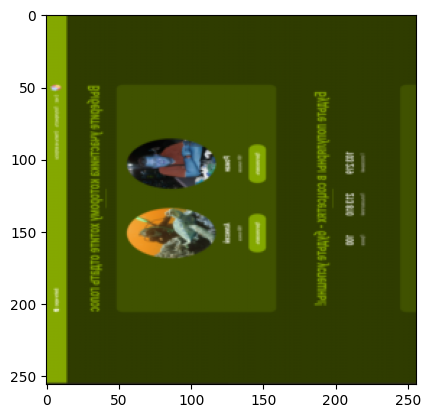


Distance: 0.69903


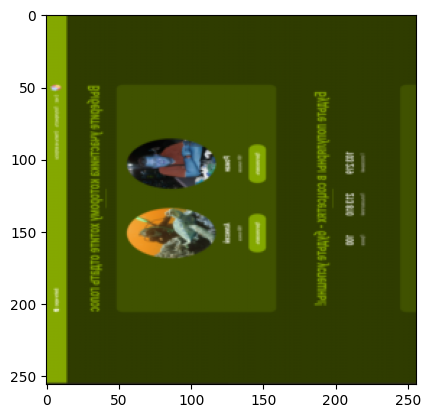


Distance: 0.68827


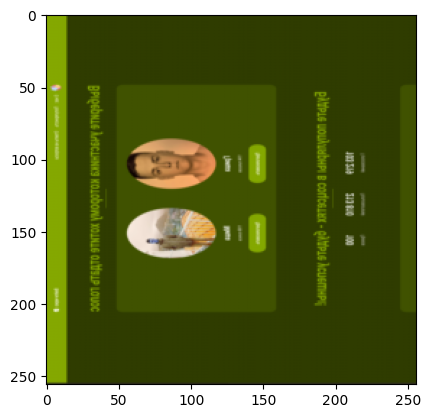


Distance: 0.68827


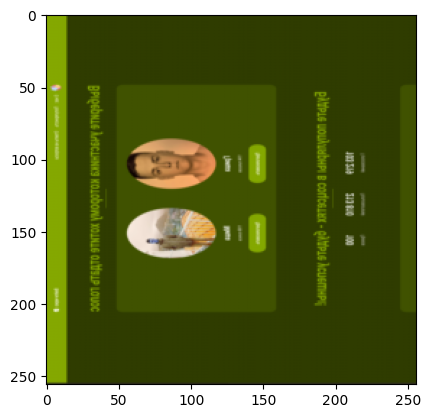


Distance: 0.66483


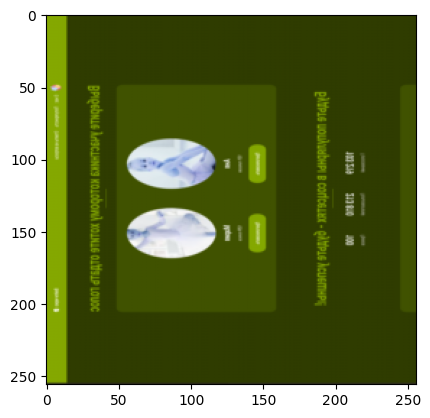


Distance: 0.65582


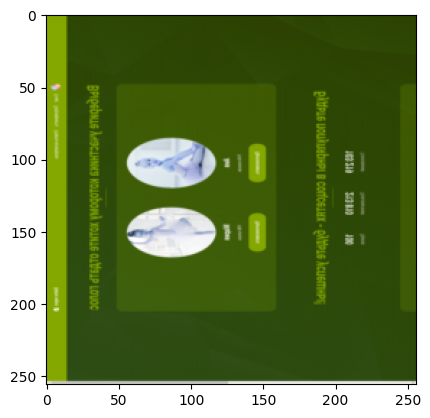


Distance: 0.65510


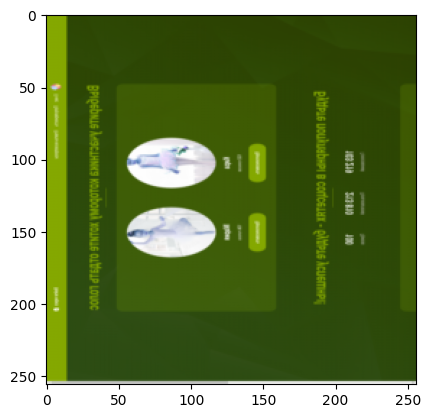


Distance: 0.65510


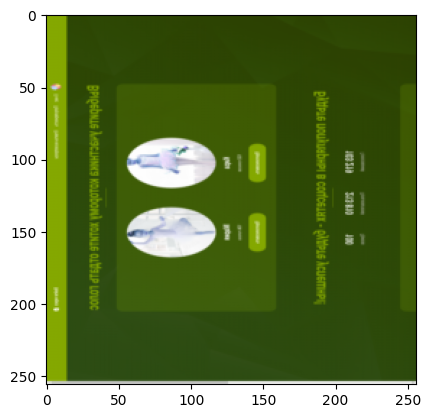


Distance: 0.65005


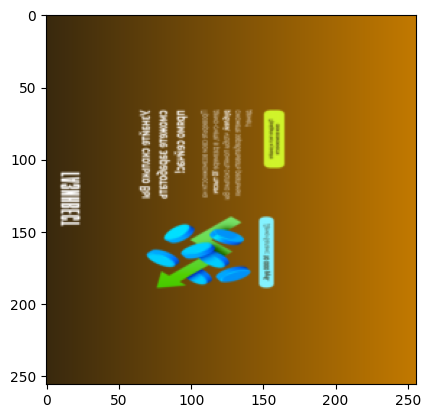


Distance: 0.65004


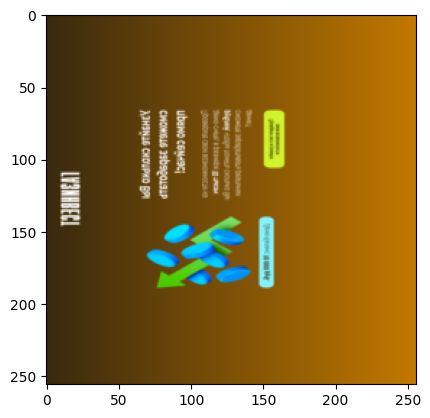


Distance: 0.65004


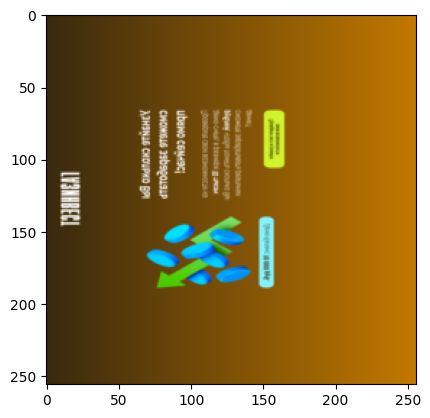


Distance: 0.65004


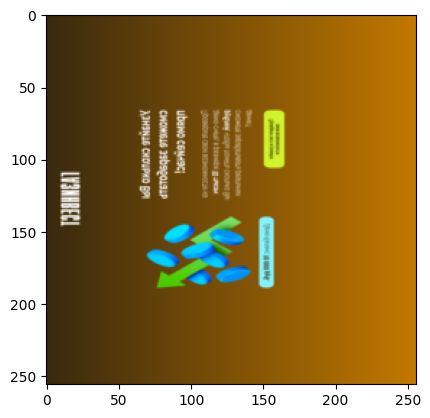


Distance: 0.64997


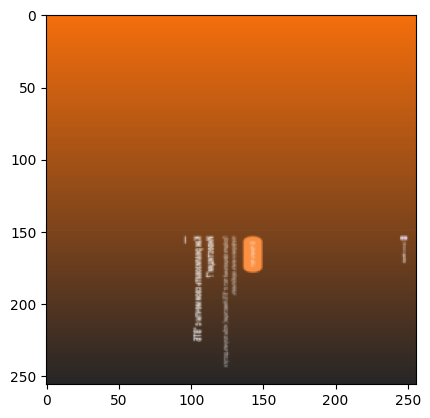


Distance: 0.64809


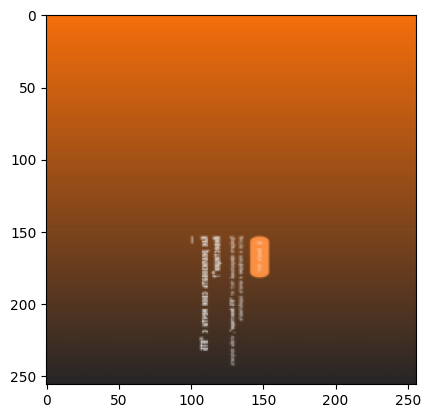


Distance: 0.64799


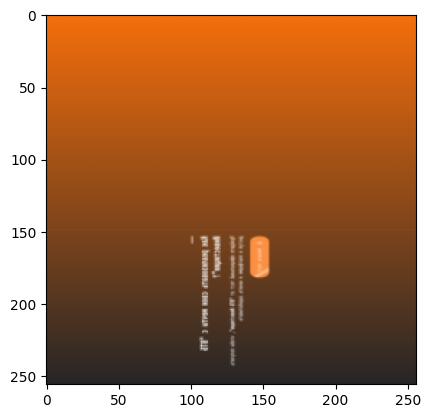


Distance: 0.64618


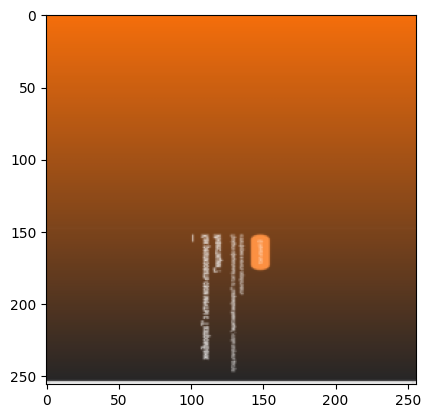


Distance: 0.64618


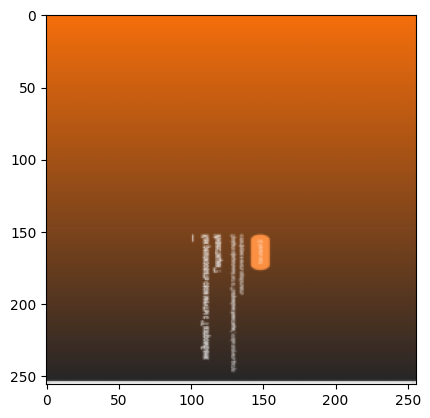


Distance: 0.64618


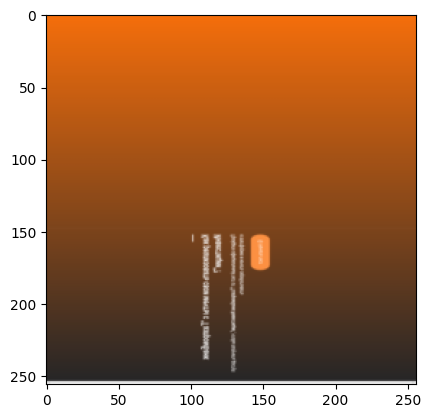


Distance: 0.64617


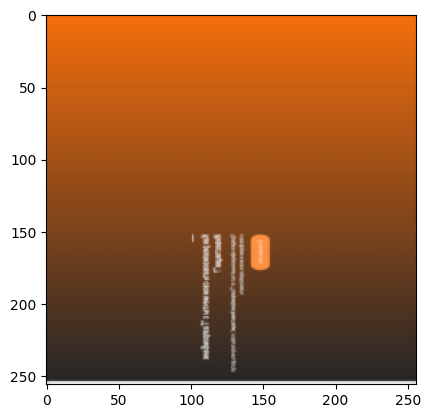


Distance: 0.64617


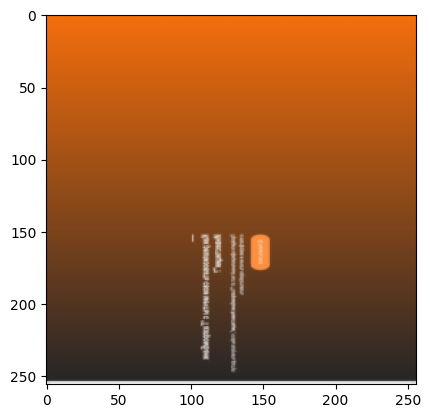


Distance: 0.64617


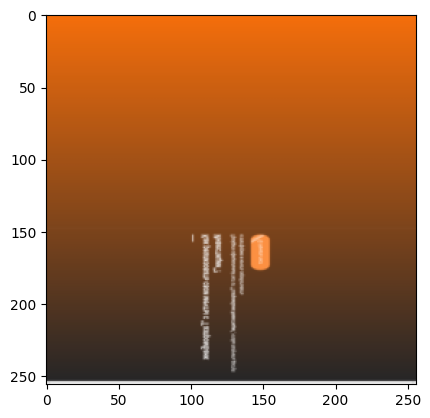


Distance: 0.64615


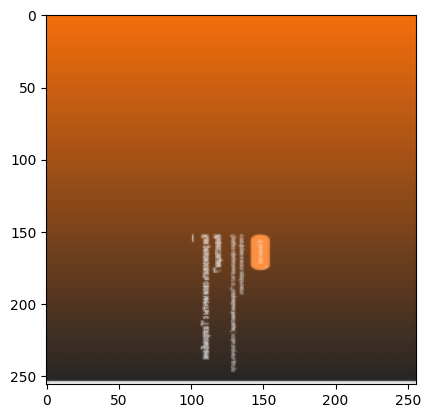


Distance: 0.64611


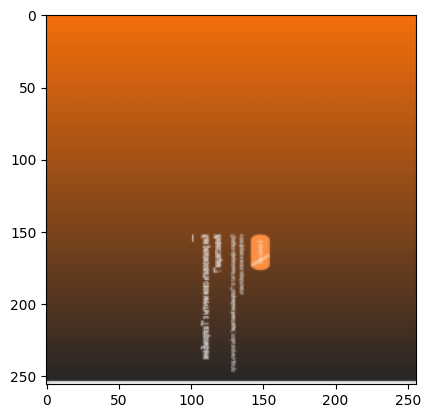


Distance: 0.64610


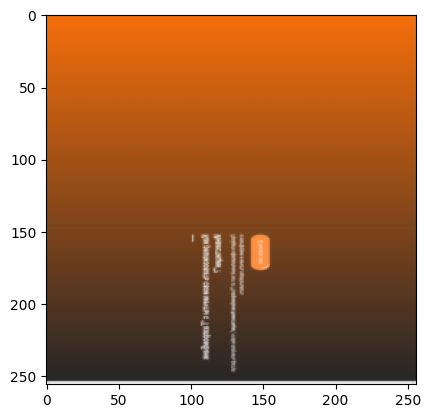


Distance: 0.64606


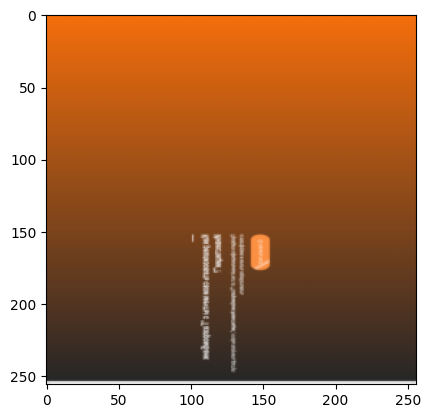


Distance: 0.64602


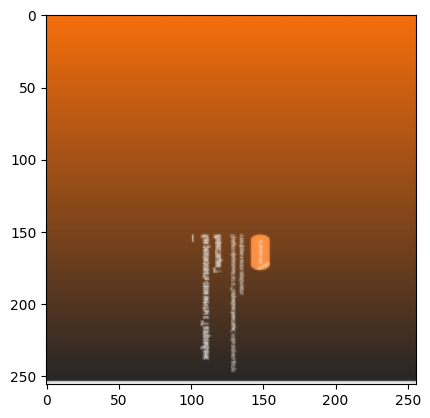


Distance: 0.64505


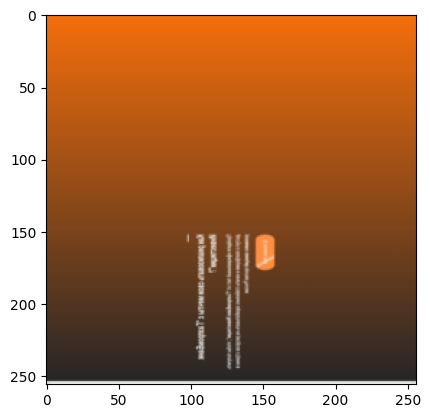


Distance: 0.62778


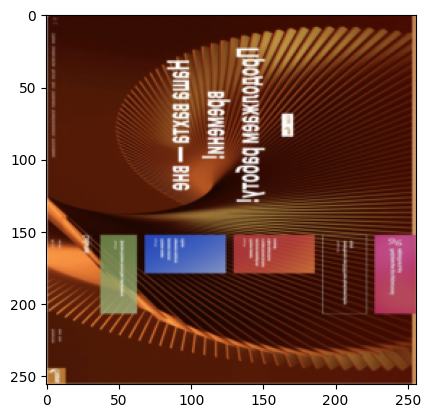


Distance: 0.62382


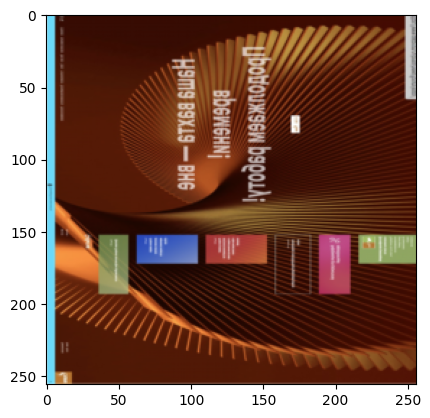


Distance: 0.60733


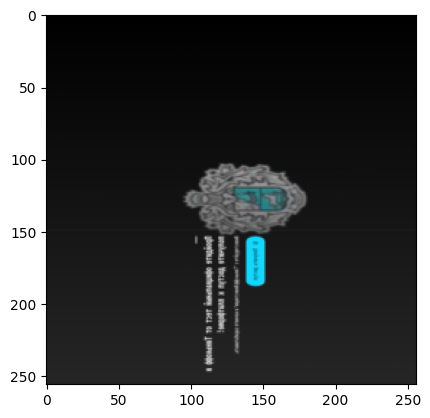


Distance: 0.60727


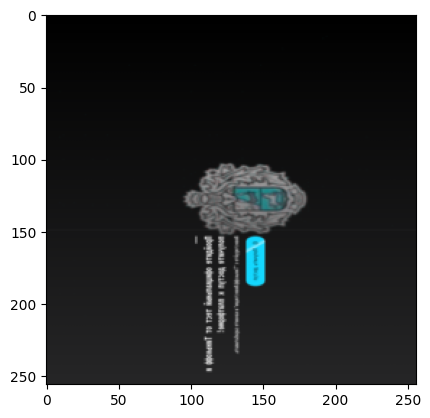


Distance: 0.60724


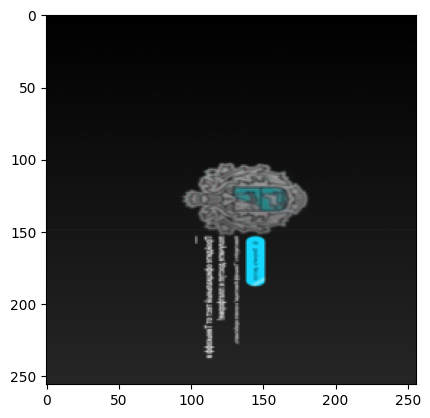


Distance: 0.60719


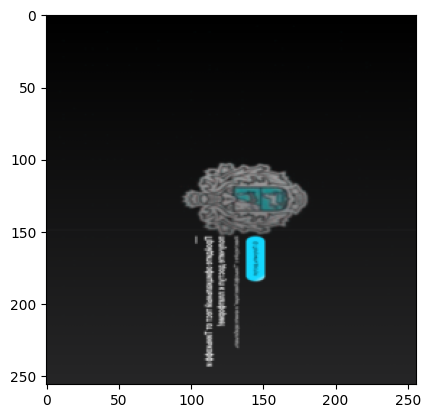


Distance: 0.60657


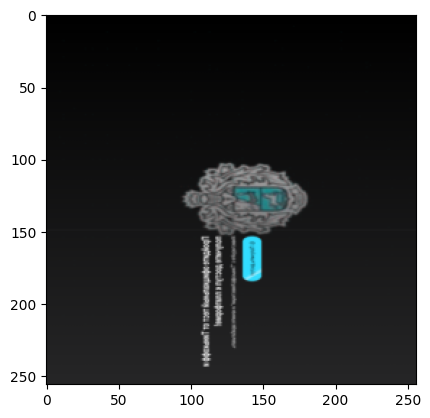


Distance: 0.60462


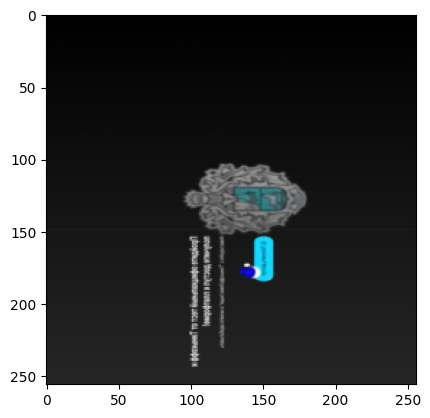


Distance: 0.60325


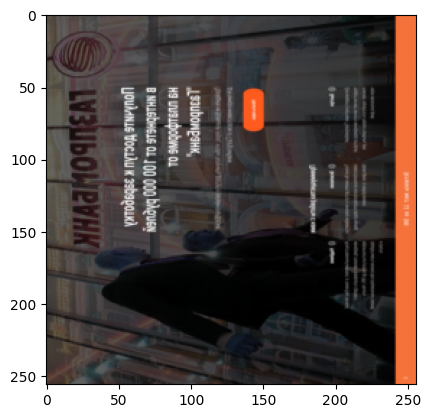


Distance: 0.60325


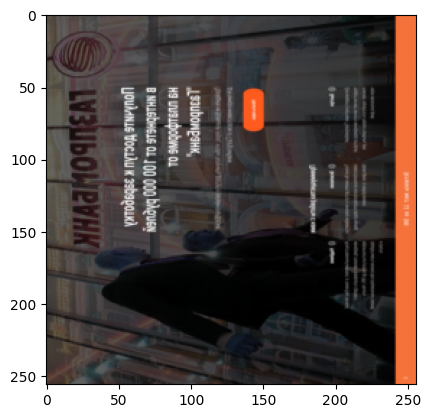


Distance: 0.60323


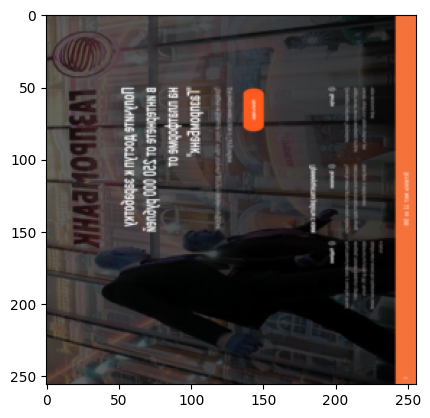


Distance: 0.59820


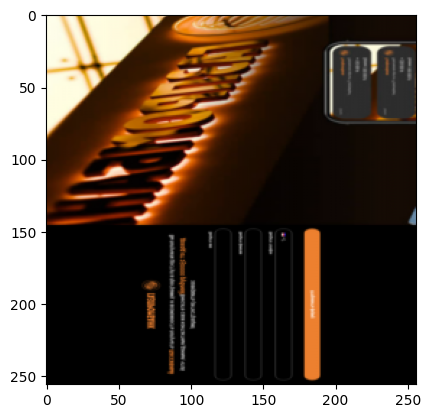


Distance: 0.59395


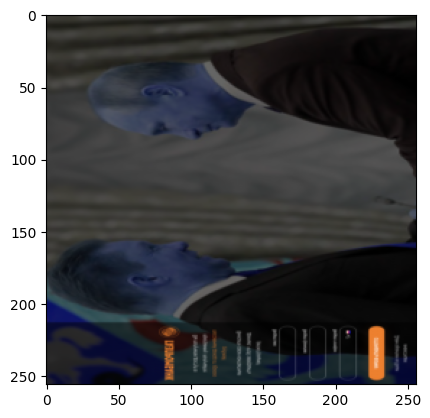


Distance: 0.59390


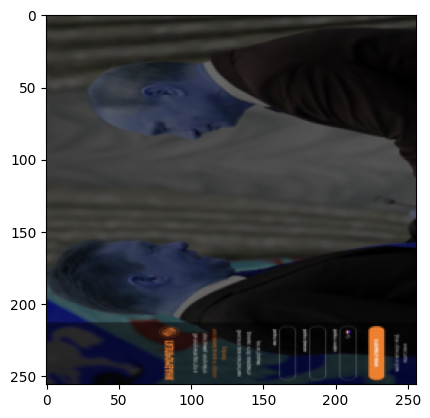


Distance: 0.58959


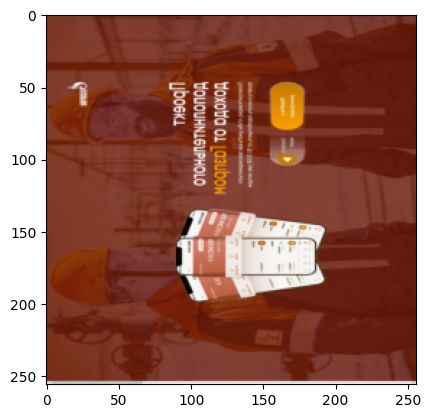


Distance: 0.58862


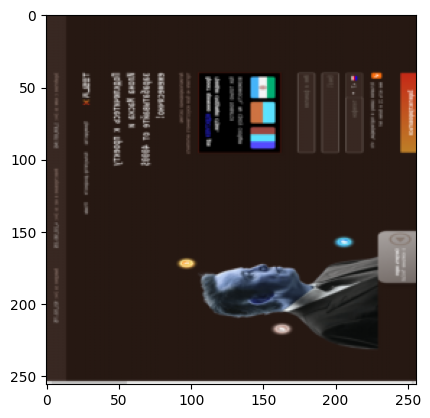


Distance: 0.58136


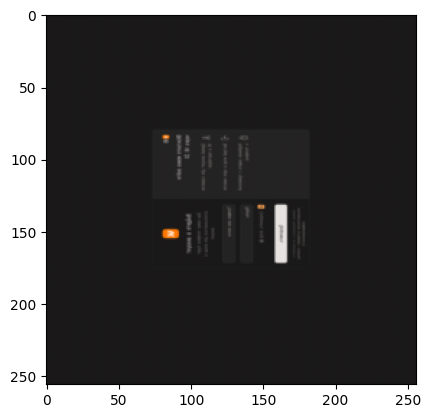


Distance: 0.57817


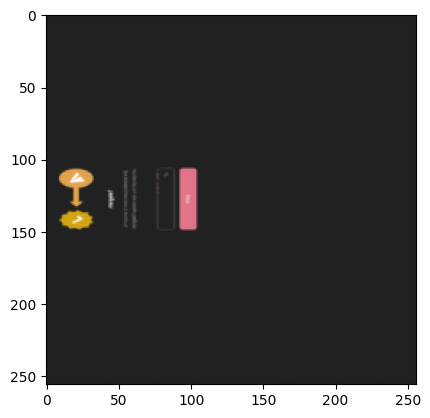


Distance: 0.57817


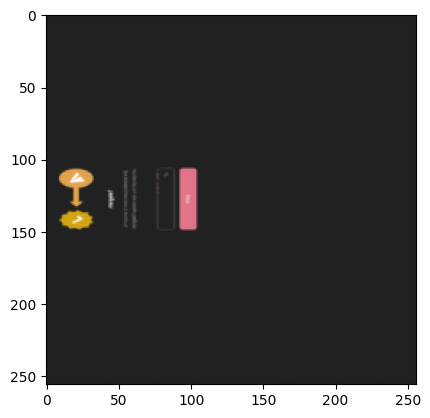


Distance: 0.57802


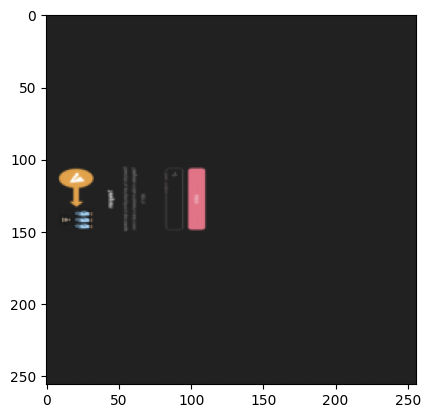


Distance: 0.57802


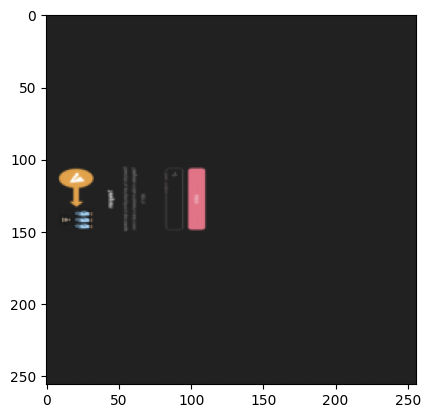


Distance: 0.57783


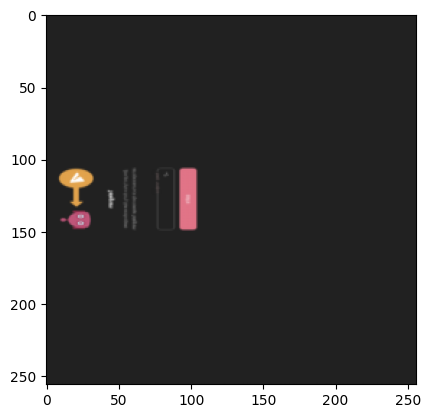


Distance: 0.57782


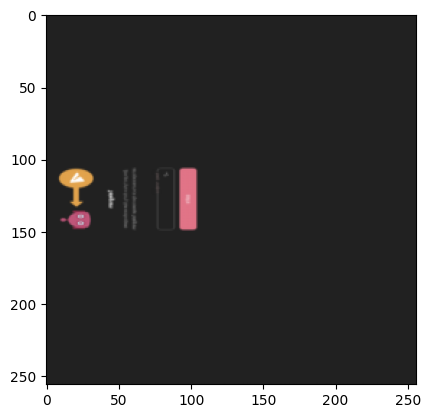

In [67]:
random_fishing_idx = np.random.choice(fishing_idxs)

analyse_embeds(train_dataset, autoencoder, random_fishing_idx)